*   Kütüphanelerin eklenmesi



In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

*  **Dataset Oluşturma Aşaması**
*   tf.keras.utils.image_dataset_from_directory() fonksiyonu resimleri değişkenlere yüklemek için kullanılır.
*   her resmi 32'e 32'lik tekrar boyutlandırıyoruz.
*   batch_size : Neural networkin bir seferinde çalışacağı resim sayısı.



In [ ]:
img_height, img_width = 32, 32
batch_size = 20

train_ds = tf.keras.utils.image_dataset_from_directory(
    "drive/MyDrive/trees/train",
    image_size = (img_height, img_width),
    batch_size = batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    "drive/MyDrive/trees/validation",
    image_size = (img_height, img_width),
    batch_size = batch_size
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    "drive/MyDrive/trees/test",
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 2225 files belonging to 15 classes.
Found 782 files belonging to 15 classes.
Found 1386 files belonging to 15 classes.


*   Train datasından bazılarını göstermek için yazdırdık. Resimlerin orjinallerinin boyutları farklı olsa bile daha önceden yeniden boyutlandırma yaptığımız için hepsi kare ve 32,32 boyutlarındalar.

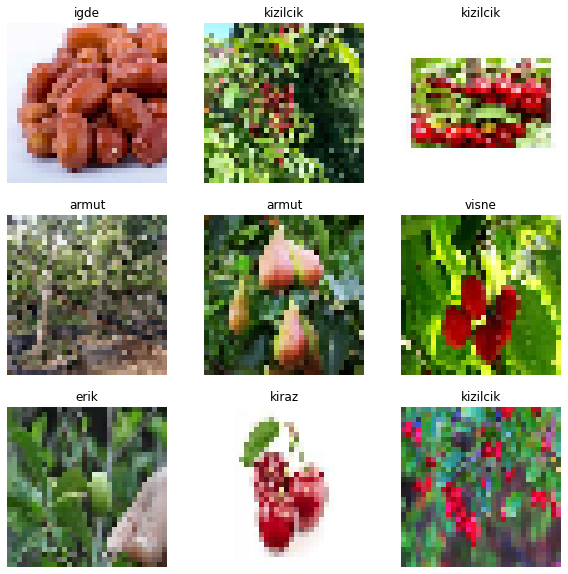

In [ ]:
class_names = ["alic", "armut", "ayva","banyan","cam","elma","erik","igde","kayisi","kiraz","kizilcik","kusburnu","muz","seftali","visne"]
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

*   **Model Oluşum Aşaması**
*   tf.keras.Sequential() : neural network katmanlarımızı ekler.
* tf.keras.layers.Rescaling() : her bir resmi rgb değerlerini 0 ile 255 arasında değerlerden 0 ile 1 arasında yeniden düzenlendik. 
* Convolutional layer : tf.keras.layers.Conv2D(32, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D() -- 3 defa uyguladık.






In [ ]:
model = tf.keras.Sequential(
    [
     tf.keras.layers.Rescaling(1./255),
     tf.keras.layers.Conv2D(32, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Conv2D(32, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Conv2D(32, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(128, activation="relu"),
     tf.keras.layers.Dense(15)
    ]
)

Modelin derlenmesi ve loss fonksiyonu

In [ ]:
model.compile(
    optimizer="adam",
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics=['accuracy']
)

Oluşturulan model train data ve validation data üzerinde epoch sayısı kadar döner ve model eğitilir.


In [ ]:
model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 30
)

Epoch 1/30
112/112 [==============================] - 298s 3s/step - loss: 2.4665 - accuracy: 0.1591 - val_loss: 2.1617 - val_accuracy: 0.1931
Epoch 2/30
112/112 [==============================] - 4s 33ms/step - loss: 1.9837 - accuracy: 0.2796 - val_loss: 1.8036 - val_accuracy: 0.3427
Epoch 3/30
112/112 [==============================] - 4s 33ms/step - loss: 1.8262 - accuracy: 0.3375 - val_loss: 1.6790 - val_accuracy: 0.3926
Epoch 4/30
112/112 [==============================] - 4s 33ms/step - loss: 1.6849 - accuracy: 0.3883 - val_loss: 1.5710 - val_accuracy: 0.4194
Epoch 5/30
112/112 [==============================] - 4s 34ms/step - loss: 1.5835 - accuracy: 0.4436 - val_loss: 1.4772 - val_accuracy: 0.4463
Epoch 6/30
112/112 [==============================] - 4s 33ms/step - loss: 1.5288 - accuracy: 0.4598 - val_loss: 1.4283 - val_accuracy: 0.4757
Epoch 7/30
112/112 [==============================] - 4s 34ms/step - loss: 1.4401 - accuracy: 0.4912 - val_loss: 1.3682 - val_accuracy: 0.4923

Train datası ve validation datası üzerinden eğitilen model, test datası üzerinden değerlendirilir.

In [ ]:
model.evaluate(test_ds)

70/70 [==============================] - 116s 1s/step - loss: 0.3727 - accuracy: 0.8680


[0.37274613976478577, 0.8679653406143188]

Test datası üzerinden rastgele alınan resimlerle model tahminde bulunur ve bu resimlerin tahmin edilen sınıfı ve gerçek sınıfı yazdırılır.

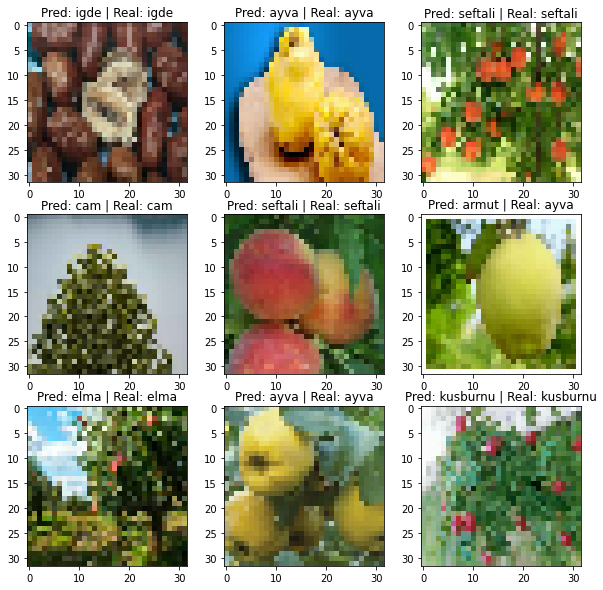

In [ ]:
import numpy

plt.figure(figsize=(10,10))
for images, labels in test_ds.take(1):
  classifications = model(images)
  # print(classifications)
  
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    index = numpy.argmax(classifications[i])
    plt.title("Pred: " + class_names[index] + " | Real: " + class_names[labels[i]])

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", 'wb') as f:
  f.write(tflite_model)